In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../utility")
from inference import recover_controls_for_trajectory, load_koopman_model
from dataset import KoopmanDatasetCollector
import torch
import pandas as pd

In [ ]:
data_collector = KoopmanDatasetCollector("Kinova", 60000, 20000, 20000, 50, normalize=False)
torque_data = data_collector.test_data.transpose(1, 0, 2).reshape(-1, 21)[:20000, :7]
state_data = data_collector.test_data.transpose(1, 0, 2).reshape(-1, 21)[:20000, 7:21]

Checkpoint keys: dict_keys(['model', 'layer'])


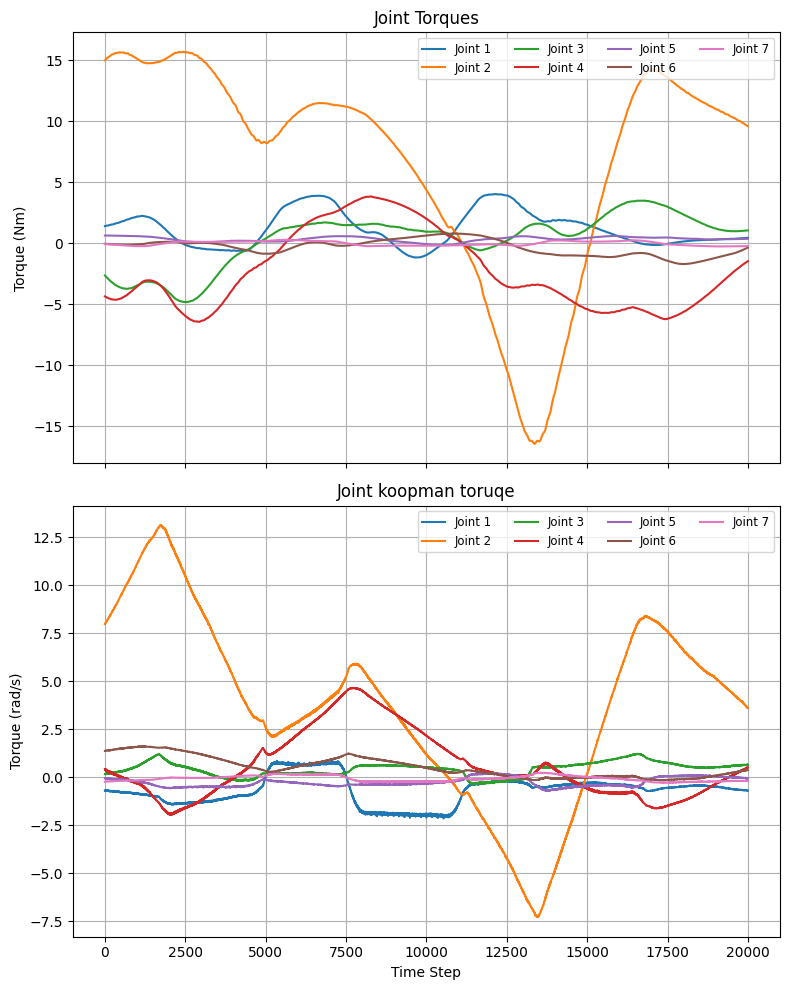

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = load_koopman_model("../log/best_models/Kinova/best_model_unnorm_Kinova_1024_1_1.pth",device)

koopman_torque_data = recover_controls_for_trajectory(state_data,net,device=device).detach().cpu().numpy()
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
# Plot torques
for i in range(7):
    axs[0].plot(torque_data[:, i], label=f'Joint {i+1}')
axs[0].set_title('Joint Torques')
axs[0].set_ylabel('Torque (Nm)')
axs[0].legend(loc='upper right', ncol=4, fontsize='small')
axs[0].grid(True)

# Plot velocities
for i in range(7):
    axs[1].plot(koopman_torque_data[:, i], label=f'Joint {i+1}')
axs[1].set_title('Joint koopman toruqe')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Torque (rad/s)')
axs[1].legend(loc='upper right', ncol=4, fontsize='small')
axs[1].grid(True)
plt.tight_layout()
plt.show()